**Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**




In [ ]:
# Importing modules
import re
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Read data into movies
movies = pd.read_csv('netflix_titles.csv')

# Print head
movies.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [ ]:

# Remove the columns
movies = movies.drop(columns=['show_id','type', 'title', 'director', 'cast','country', 'date_added','release_year','rating','duration','listed_in'], axis=1)

# sample only 100 movies
movies = movies.sample(100)

# Print out the first rows of papers
movies.head()

,description
563,When diabolical genius Dr. Evil travels back i...
2669,To replace his grandfather as head of a cartel...
5904,"Filmed in his hometown of Atlanta, Chris Tucke..."
8725,A popular high school girl strains her relatio...
1003,A shy teen with the power to turn invisible mu...


In [ ]:

# Load the regular expression library
import re

# Remove punctuation
movies['description_processed'] = movies['description'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
movies['description_processed'] = movies['description_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
movies['description_processed'].head()

movies['description_processed'].to_csv('h_modified.csv')

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = movies.description_processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['when', 'diabolical', 'genius', 'dr', 'evil', 'travels', 'back', 'in', 'time', 'to', 'steal', 'superspy', 'austin', 'powers', 'mojo', 'austin', 'must', 'return', 'to', 'the', 'swingin', 'himself']


In [ ]:

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 6.9 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

['construction', 'magnate', 'take', 'struggle', 'newspaper', 'attempt', 'wield', 'editorial', 'influence', 'power', 'personal', 'gain']


In [ ]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]


In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:

from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"half" + 0.015*"meet" + 0.015*"subsequent" + 0.015*"decide" + '
  '0.015*"girl" + 0.015*"death" + 0.015*"grandparent" + 0.015*"discover" + '
  '0.015*"former" + 0.015*"life"'),
 (1,
  '0.017*"bug" + 0.017*"world" + 0.017*"life" + 0.009*"earn" + '
  '0.009*"violence" + 0.009*"charge" + 0.009*"devotion" + 0.009*"addict" + '
  '0.009*"public" + 0.009*"fierce"'),
 (2,
  '0.024*"break" + 0.024*"big" + 0.024*"new" + 0.024*"great" + 0.012*"stone" + '
  '0.012*"breadwinner" + 0.012*"home" + 0.012*"still" + 0.012*"first" + '
  '0.012*"history"'),
 (3,
  '0.025*"come" + 0.013*"encounter" + 0.013*"rhythmic" + 0.013*"decimate" + '
  '0.013*"companion" + 0.013*"alone" + 0.013*"inspire" + 0.013*"woman" + '
  '0.013*"new" + 0.013*"world"'),
 (4,
  '0.015*"instrument" + 0.015*"intimate" + 0.015*"fiery" + 0.015*"glide" + '
  '0.015*"ice" + 0.015*"season" + 0.015*"skate" + 0.015*"star" + 0.015*"strap" '
  '+ 0.015*"guard"'),
 (5,
  '0.028*"life" + 0.019*"take" + 0.019*"challenge" + 0.019*"

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.485094028449081

Coherence Score:  0.32754185875287795


In [ ]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
  inflating: mallet-2.0.8/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/mallet-2.0.8/
  inflating: __MACOSX/mallet-2.0.8/._.DS_Store  
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
   creating: __MACOSX/mallet-2.0.8/bin/
  inflating: __MACOSX/mallet-2.0.8/bin/._classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: __MACOSX/mallet-2.0.8/bin/._csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: __MACOSX/mallet-2.0.8/bin/._csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: __MACOSX/mallet-2.0.8/bin/._mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: __MACOSX/mallet-2.0.8/bin/._mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: __MACOSX/mallet-2.0.8/bin/._mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: __MACOSX/mallet-2.0.8/bin/._prepend-license.sh  
  inflating: mallet-2.0.8/bi

In [ ]:
mallet_path = 'mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

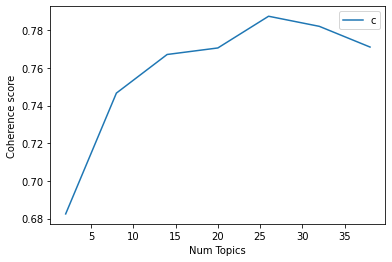

In [ ]:
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

The coherence values and number of topics which are k-values are plotted between x and y axis .we can observe from the above plot that values are varying frequently so I am considering the value of k as 7

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6825
Num Topics = 8  has Coherence Value of 0.7466
Num Topics = 14  has Coherence Value of 0.7671
Num Topics = 20  has Coherence Value of 0.7706
Num Topics = 26  has Coherence Value of 0.7874
Num Topics = 32  has Coherence Value of 0.7821
Num Topics = 38  has Coherence Value of 0.7711


**Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

Documnets count: 101
[(0, '0.262*"man" + 0.261*"life" + 0.229*"becom" + 0.191*"friend" + 0.162*"live" + 0.143*"must" + 0.137*"year" + 0.131*"take" + 0.125*"old" + 0.118*"woman"'), (1, '-0.336*"life" + 0.254*"take" + 0.185*"man" + 0.179*"forc" + -0.159*"old" + 0.157*"live" + -0.149*"year" + -0.142*"back" + 0.139*"friend" + -0.129*"help"'), (2, '-0.346*"must" + 0.343*"life" + -0.172*"power" + -0.168*"evil" + 0.134*"live" + 0.129*"woman" + -0.129*"save" + -0.124*"austin" + -0.124*"put" + -0.124*"asid"'), (3, '0.411*"man" + -0.333*"friend" + -0.203*"band" + -0.154*"stori" + 0.131*"must" + -0.119*"shi" + -0.114*"school" + -0.110*"dream" + -0.103*"share" + -0.103*"one"'), (4, '-0.268*"take" + -0.243*"life" + -0.216*"forc" + 0.215*"becom" + 0.207*"murder" + 0.158*"world" + 0.150*"documentari" + 0.114*"film" + -0.110*"mission" + -0.099*"command"'), (5, '-0.227*"home" + 0.225*"friend" + -0.175*"famili" + -0.164*"film" + 0.160*"must" + 0.159*"live" + -0.147*"take" + -0.135*"year" + -0.128*"death

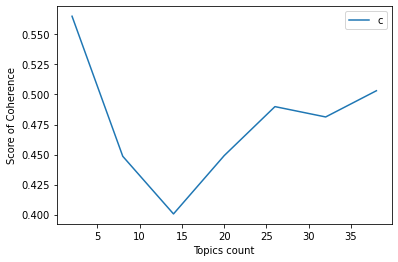

In [ ]:
def load_data(path,file_name):
    doc_list = []
    headings=[]
    with open( os.path.join(path, file_name) ,"r") as findings:
        for line in findings.readlines():
            heading_text = line.strip()
            doc_list.append(heading_text)
    print("Documnets count:",len(doc_list))
    headings.append( heading_text[0:min(len(heading_text),100)] )
    return doc_list,headings

# Prepocessing the text file
def preprocess_data(doc_set):
    # step 1: tokenizing text
    tokenizer = RegexpTokenizer(r'\w+')
    eng_stop_words = set(stopwords.words('english'))
    porter_stem = PorterStemmer()
    text_data = []
    # to get tokenized documents
    for val in doc_set:
        raw_data = val.lower()
        tokens = tokenizer.tokenize(raw_data)
        # step 2: removing stop words 
        stopped_tokens = [val for val in tokens if not val in eng_stop_words]
        # step 3: Performing steming
        stemmed_tokens = [porter_stem.stem(val) for val in stopped_tokens]
        text_data.append(stemmed_tokens)
    return text_data

# creating a document-term matrix and a dictionary of terms .
def prepare_corpus(doc_clean):
    # Creating the term dictionary 
    term_dict = corpora.Dictionary(doc_clean)
    # Using above dictionary converting the list of documents (corpus) into Document Term Matrix
    term_doc_matrix = [term_dict.doc2bow(doc) for doc in doc_clean]
    # to generate LDA model
    return term_dict,term_doc_matrix

# generating  LSA.
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    term_dict,term_doc_matrix=prepare_corpus(doc_clean)
    # train model
    lsamodel = LsiModel(term_doc_matrix, num_topics=number_of_topics, id2word = term_dict)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

# generate coherence scores to determine an optimum number of topics
def compute_coherence_values(term_dict, term_doc_matrix, doc_clean, stop, start=2, step=3):
    coh_values = []
    mod_list = []
    for num_of_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(term_doc_matrix, num_topics=num_of_topics, id2word = term_dict)  # train model
        mod_list.append(model)
        coh_model = CoherenceModel(model=model, texts=doc_clean, dictionary=term_dict, coherence='c_v')
        coh_values.append(coh_model.get_coherence())
    return mod_list, coh_values

# plot coherence score values and show graph
def plot_graph(doc_clean,start, stop, step):
    term_dict,term_doc_matrix=prepare_corpus(doc_clean)
    mod_list, coh_values = compute_coherence_values(term_dict, term_doc_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coh_values)
    plt.xlabel("Topics count")
    plt.ylabel("Score of Coherence")
    plt.legend(("coh_values"), loc='best')
    plt.show()
number_of_topics=7
words=10
document_list,titles=load_data("","h_modified.csv")
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)
start,stop,step=2,40,6
plot_graph(clean_text,start,stop,step)

The coherence values and number of topics are plotted between x-axis and y-axis ,where we can observe that values of k is constant at 24 so I am considered that as perfect for this LSA

**Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details**

The latent Dirichlet allocation (LDA) is known as  statistical model that allows sets of observations to be explained by unobserved groups.Let us consider an example, such as observations are words collected into documents as shown in 1 st question and that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an perfect example as machine learning model and also it is widely used artificial intelligence projects in day-to-day life . For the 1st question ,I have calculated LDA k values as 7 and coherence value as 0.73 .
The main objective of LSA is reducing dimension for classification. The idea is that words will occurs in similar pieces of text if they have similar meaning. We usually use Latent Semantic Indexing (LSI) as an alternative name in NLP field.
Firstly, we have m documents and n words as input. An m * n matrix can be constructed while column and row are document and word respectively as 2 nd question .where we can use count occurrence or TF-IDF score. However, TF-IDF is better than count occurrence in most of the time as high frequency do not account for better classification. Word importance will be high if the number of occurrence within same document and On the other hand, it will be decreased if it occurs in corpus as shown in 2 nd question 
The  main disadvantage is that the matrix is very sparseand noisy . In the 2 nd question,I am considering the number of topics as 24 and coherence values is 0.52 .By observing both LDA and LSA I can that LDA would be better option has it has more coherence values.